In [1]:
import sys
sys.path.append("/home/ubuntu/intelliscope/modules") # go to parent dir
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow_addons.layers import InstanceNormalization
import tensorflow_addons as tfa
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import custom_metrics
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from intelliscope import instead_data_loaders
from sklearn.metrics import classification_report
import numpy as np
from neptunecontrib.monitoring.metrics import *
plt.style.use('seaborn')


def get_individual_metrics(y_test, y_pred, names):
    patient_preds={}
    for i in range(len(names)): # create dict: patient_record_name: [start_point, label, [pred0, pred1]] 
        name=names[i]
        record_name,record_start_point,_=name.strip().split('_')
        if record_name in patient_preds:
            patient_preds[record_name].append([int(record_start_point),y_test[i], list(y_pred[i])])
        else:
            patient_preds[record_name]=[[int(record_start_point),y_test[i], list(y_pred[i])]]

    y_test_bulk, y_pred_bulk=[],[]    
    for key in patient_preds: # return :: patient-wise y_test, y_preds
        patient_pred=patient_preds[key]
        label, pred_label=get_single_patient_pred(patient_pred, mean)

        y_test_bulk.append(label)
        y_pred_bulk.append(pred_label)

    y_test_bulk=np.array(y_test_bulk)
    y_pred_bulk=np.array(y_pred_bulk)
    
    return y_test_bulk, y_pred_bulk

def get_single_patient_pred(patient_pred, func):
    #print(patient_pred)
    patient_pred.sort()
    
    y=np.array(patient_pred)[:,1]
    
    assert y.sum()%(y.shape[0])==0
    label=y[0] # label of the patient
    
    rows=[]
    for row in sorted(patient_pred):
        rows.append(list(row[2]))
    rows=np.array(rows)

    y_preds=np.argmax(rows, axis=1)
    pred_label=func(y_preds)
    return label, pred_label

def mean(list_):
    metric=np.mean(list_)
    return [1-metric,metric]

In [2]:
projects=['HYBIM','HYBRID','HYBRID','HYBIM','HYBRID','HYBRID', 'PCG', 'ECG']
model_nums=['7','21','28','31','13','12', '41', '31']
optimal_thresholds=[0.8, 0.5, 0.24419, 0.666667, 0.5, 0.12357, 0.5, 0.5] 
names=['A','B','C','D','E','F', 'G', 'H']
eval_type=['recordwise','recordwise','samplewise','recordwise','recordwise','samplewise', 'samplewise', 'samplewise']

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def get_single_stream_data(ecgorpcg):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
            '/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/'+ecgorpcg+'/balanced'+'/test',  # this is the target directory
            target_size=(272, 462), 
            batch_size=len(os.listdir('/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/ecg/balanced'+'/test/1'))+len(os.listdir('/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/ecg/balanced'+'/test/0')),
            class_mode='categorical', seed=7)

    x_test,Y_test = test_generator.next()
    y_test_pred = model.predict(x_test)
    
    return Y_test, y_test_pred

In [4]:

fprs=[]
tprs=[]
thress=[]
basepath = '/home/ubuntu/intelliscope/models/'

for i in range(len(projects)):
    PARAMS = {
        'dataset':'physionet2016a',
        'pcg_dir':'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/pcg/',  
        'ecg_dir':'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataA/ecg/', 
    }
    
    project=projects[i]
    model_number=model_nums[i]
    threshold = optimal_thresholds[i]
    
    path = basepath + 'Experiment(' + project + '-' + model_number + ').h5'
    
    model = load_model(path)

    if project=='HYBIM':
        PARAMS['data_balanced']=False
    elif project=='HYBRID':
        PARAMS['data_balanced']=True
    elif project=='PCG':
        PARAMS['data_balanced']=True
    elif project=='ECG':
        PARAMS['data_balanced']=True

    
    if PARAMS['data_balanced']==True:
        PARAMS['pcg_dir']+='balanced'
        PARAMS['ecg_dir']+='balanced'
    else:
        PARAMS['pcg_dir']+='imbalanced'        
        PARAMS['ecg_dir']+='imbalanced'        

    #print(PARAMS['pcg_dir'],PARAMS['ecg_dir'])


    if project=='PCG' or project=='ECG':
        Y_test, y_test_pred =get_single_stream_data(project.lower())
        names_test=None # we will not evaluate recordwise for this
    elif project=='HYBRID' or project=='HYBIM':    
        X_test,Y_test,names_test = instead_data_loaders(PARAMS,'test',True)
        X_test_pcg = X_test[:,:,:,0:3]/255.0
        X_test_ecg = X_test[:,:,:,3:6]/255.0
        y_test_pred = model.predict([X_test_pcg,X_test_ecg], batch_size=X_test.shape[0], verbose=1)
    
    
    y_test=np.argmax(Y_test,axis=1)
    if eval_type[i]=='recordwise':
        y_test, y_test_pred = get_individual_metrics(y_test, y_test_pred, names_test)

    metrics=custom_metrics._class_metrics(y_test, y_test_pred[:, 1] > threshold)

    tpr1=metrics['true_positive_rate']
    tnr1=metrics['true_negative_rate']

    print(project,model_number)
    print(threshold, path)
    print(f'TPR : {tpr1}, TNR : {tnr1}')

    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:, 1])
    roc_auc = roc_auc_score(y_test, y_test_pred[:, 1])
    print(f'ROC score : {roc_auc}')


    fprs.append(fpr)
    tprs.append(tpr)
    thress.append(thresholds)
    


Total  707
199 Images loaded across 2 Categories. Ignored blanks  60
508 Images loaded across 2 Categories. Ignored blanks  9
638 Total After removing blanks
638/638 [==============================] - 3s 5ms/sample
HYBIM 7
0.8 /home/ubuntu/intelliscope/models/Experiment(HYBIM-7).h5
TPR : 0.8771929824561403, TNR : 0.875
ROC score : 0.9375
Total  388
197 Images loaded across 2 Categories. Ignored blanks  0
191 Images loaded across 2 Categories. Ignored blanks  16
372 Total After removing blanks
372/372 [==============================] - 2s 5ms/sample
HYBRID 21
0.5 /home/ubuntu/intelliscope/models/Experiment(HYBRID-21).h5
TPR : 0.8571428571428571, TNR : 0.8260869565217391
ROC score : 0.870600414078675
Total  388
197 Images loaded across 2 Categories. Ignored blanks  0
191 Images loaded across 2 Categories. Ignored blanks  16
372 Total After removing blanks
372/372 [==============================] - 2s 5ms/sample
HYBRID 28
0.24419 /home/ubuntu/intelliscope/models/Experiment(HYBRID-28).h5
T

## With gray background

In [12]:
colors[::-1]

array([[0.4       , 0.4       , 0.4       , 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.90196078, 0.67058824, 0.00784314, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.90588235, 0.16078431, 0.54117647, 1.        ],
       [0.45882353, 0.43921569, 0.70196078, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.10588235, 0.61960784, 0.46666667, 1.        ]])

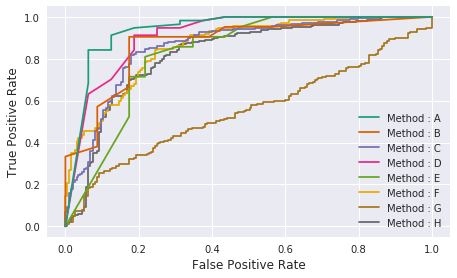

In [25]:
import matplotlib.cm as cm

fig=plt.figure(figsize=(7,4))
ax=fig.add_axes([0.12,0.12,0.8,0.8])

colors = cm.Dark2(np.linspace(0,1, len(fprs)))
for i in range(len(projects)):
    ax.plot(fprs[i],tprs[i], label='Method : '+names[i], color=colors[i], zorder=15-i)


ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
#plt.grid(color='black', linestyle='-.', linewidth=0.7)
ax.axis('on')
#ax.set_facecolor('white')
ax.legend()
#ax.axhline(y=0, color='k')
#ax.axvline(x=0, color='k')
plt.savefig('ROC_dark2.pdf')
plt.savefig('ROC_dark2.eps')
plt.show()


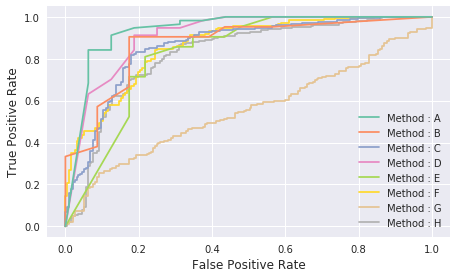

In [26]:
import matplotlib.cm as cm

fig=plt.figure(figsize=(7,4))
ax=fig.add_axes([0.12,0.12,0.8,0.8])

colors = cm.Set2(np.linspace(0,1, len(fprs)))
for i in range(len(projects)):
    ax.plot(fprs[i],tprs[i], label='Method : '+names[i], color=colors[i], zorder=15-i)


ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
#plt.grid(color='black', linestyle='-.', linewidth=0.7)
ax.axis('on')
#ax.set_facecolor('white')
ax.legend()
#ax.axhline(y=0, color='k')
#ax.axvline(x=0, color='k')
plt.savefig('ROC_set2.pdf')
plt.savefig('ROC_set2.eps')
plt.show()


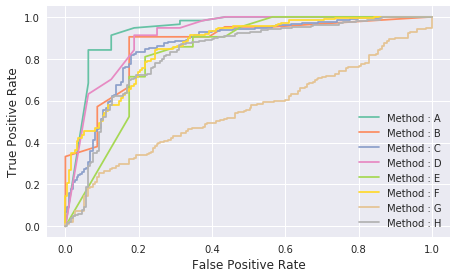

In [23]:
import matplotlib.cm as cm

fig=plt.figure(figsize=(7,4))
ax=fig.add_axes([0.12,0.12,0.8,0.8])

colors = cm.Set2(np.linspace(0,1, len(fprs)))
for i in range(len(projects)):
    ax.plot(fprs[i],tprs[i], label='Method : '+names[i], color=colors[i], zorder=15-i)


ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
#plt.grid(color='black', linestyle='-.', linewidth=0.7)
ax.axis('on')
#ax.set_facecolor('white')
ax.legend()
#ax.axhline(y=0, color='k')
#ax.axvline(x=0, color='k')
plt.savefig('ROC_set2.pdf')
plt.savefig('ROC_set2.eps')
plt.show()


In [32]:
colors = cm.Accent(np.linspace(0,1, len(fprs)))

colors[]=[1, 217/255., 47/255.,1]

array([0.49803922, 0.78823529, 0.49803922, 1.        ])

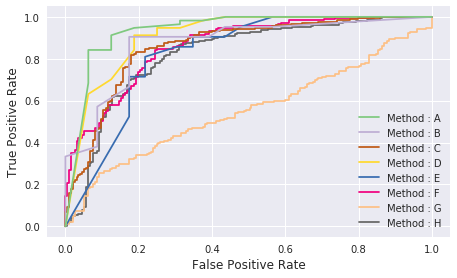

In [44]:
import matplotlib.cm as cm

fig=plt.figure(figsize=(7,4))
ax=fig.add_axes([0.12,0.12,0.8,0.8])

colors = cm.Accent(np.linspace(0,1, len(fprs)))


colors[2], colors[-2]=colors[-2].copy(), colors[2].copy()
colors[3]=[1, 217/255., 47/255.,1]
for i in range(len(projects)):
    ax.plot(fprs[i],tprs[i], label='Method : '+names[i], color=colors[i], zorder=15-i)


ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
#plt.grid(color='black', linestyle='-.', linewidth=0.7)
ax.axis('on')
#ax.set_facecolor('white')
ax.legend()
#ax.axhline(y=0, color='k')
#ax.axvline(x=0, color='k')
plt.savefig('ROC_custom.pdf')
plt.savefig('ROC_custom.eps')
plt.show()


## With white backgroud

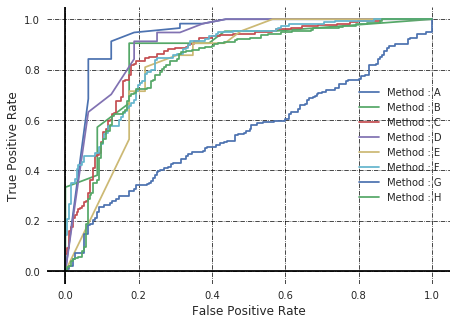

In [6]:
fig=plt.figure()
ax=fig.add_axes([0.3,0.3,0.7,0.7])

for i in range(len(projects)):
    ax.plot(fprs[i],tprs[i], label='Method : '+names[i])

#plt.title('ROC Curve', fontsize=20, fontweight="bold")
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)

plt.grid(color='black', linestyle='-.', linewidth=0.7)

ax.axis('on')
ax.set_facecolor('white')
ax.legend()


ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

#seaborn.despine(ax=ax, offset=0) # the important part here

#plt.margins(0)
plt.savefig('ROC.pdf')

